#### The program in this Jupyter notebook is mainly based on the work of Raissi et al.(2019). For more details refer to reference [3]

# Problem Statment

Consider the following PDE

$$
u_t = -uu_x + \nu u_{xx}, \quad x \in [-1, 1], \quad t \in [0, 1]
$$

Where $\nu$ is the diffusion coefficient.For our exmaple, we will use $\nu = 0.01 / \pi$.

The PDE is subject to the following initial and boundary conditions.

$$
u(x, 0) = -sin(\pi x),\\
u(-1, t) = u(1, t) = 0
$$

# Reference solution

It is possible to obtain the analytical solution for Burgers equation for a restricted set of initial conditions functions, $u(x,t=0) = g(x)$. This can be done by using the Cole-Hopf transformation, which is a nonlinear transformation.[1]
$$
u(x, t) = -2 \nu \frac{\theta_x}{\theta} = -2 \nu \log[\theta(x,t)]
$$

This transformation turns the nonlinear Burgers PDE into the heat equation
$$
\theta_t = \nu \theta_{xx}
$$

For the sake of making the code general when changing the initial conditions (or even the boundary conditions), we are going to use the explicit finite difference (conditionally stable) to approximate the solution for Burgers equation and that approximation will be our reference solution.

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from math import pi
from torch import nn

In [ ]:
def plot_result(x_axis, y_axis, u, title="u(x,t)", xlabel="x", ylabel="t"):
  x_grid, y_grid = np.meshgrid(x_axis, y_axis, indexing="xy")
  figure = plt.figure(tight_layout=True)
  ax = figure.add_subplot(111)
  colormap = ax.pcolormesh(x_grid, y_grid, u, cmap="jet")
  figure.colorbar(colormap)

  #labels and styling
  ax.set_title(title)
  ax.set_xlabel(xlabel)
  ax.set_ylabel(ylabel)
  plt.show()
  return

# Finite Difference Discretization

We will discretized the x-dimension into $n$ sub-intervals with $n+1$ points using a step size of $\Delta x = h$

$$
x_i = x_0 + ih, \quad x_0 = -1, \quad i = 0, 1, 2, \dots, n.
$$  

The time will be discretized using a step of $\Delta t = k$.

$$
t_j = t_0 + jk, \qquad t_0 = 0, \quad j = 0, 1, 2, \dots
$$

For the first derivative in time, we are going to use the forward difference (since it explicit). For the x-axis discretization, we are going to use the central difference for the first and the second derivative.

$$
u_t \approx \frac{u_{i,j+1} - u_{i, j-1}}{k}, \quad
u_x \approx \frac{ u_{i+1,j} - u_{i-1,j} }{2h}, \quad
u_x \approx \frac{ u_{i+1,j} - 2 u_{i,j} + u_{i-1,j} }{h^2}
$$

The discretized equation becomes the following

$$
\frac{u_{i,j+1} - u_{i, j-1}}{k} =
- u_{i,j} \left( \frac{ u_{i+1,j} - u_{i-1,j} }{2h} \right)
+ \nu \left( \frac{ u_{i+1,j} - 2 u_{i,j} + u_{i-1,j} }{h^2} \right)
$$

Rerrange

$$
u_{i,j+1}  = u_{i, j-1}
- k u_{i,j} \left( \frac{ u_{i+1,j} - u_{i-1,j} }{2h} \right)
+ k \nu \left( \frac{ u_{i+1,j} - 2 u_{i,j} + u_{i-1,j} }{h^2} \right)
$$

For $i=1, 2, \dots, n-1.  \quad j = 1, 2, \dots$

The initial and boundary points are the following
$$
u_{i,0} = \sin(\pi x_i), \qquad u_{0,j} = u_{n,j} = 0
$$

Our scheme is compelete and now we can impelement.

In [ ]:
def init_cond(x):
  return np.array(-np.sin(x * pi))

In [ ]:
#first derivative centeral difference
def cent_diff_1st(input, step_size):
  output = np.array(input)
  output[1:-1] = ( output[2: ] - output[:-2] ) / ( 2 * step_size )
  return output

#second derivative centeral difference
def cent_diff_2nd(input, step_size):
  output = np.array(input)
  output[1:-1] = ( output[2: ] - 2 * output[1:-1] + output[:-2] ) / step_size**2
  return output

In [ ]:
def burgers_FD(x_0=-1.0, x_f=1.0, t_0=0.0, t_f=1.0,
               v=0.01/pi, dt=0.001, dx=0.005,
               show_plot=True, return_axes=False):
  #Define some constants
  c1 = dt / (2*dx)
  c2 = (v * dt) / dx**2

  x_axis = np.arange(x_0, x_f + dx, dx)
  t_axis = np.arange(t_0, t_f + dt, dt)
  u = np.array([ init_cond(x_axis) ])#start from the initial condition

  #start the time marching scheme
  for i in range(len(t_axis) - 1):
    u_prev = u[-1]
    u_next = u_prev - dt * u_prev * cent_diff_1st(u_prev, dx) \
              + v * dt * cent_diff_2nd(u_prev, dx)

    #apply the boundary conditions
    u_next[0], u_next[-1] = 0, 0

    #add the next step to the solution and update the previous step
    u = np.append(u, [u_next], axis=0)
    u_prev = u_next

  if show_plot:
    plot_result(t_axis, x_axis, u.T,
                title="FD approximation of u(x,t)",
                xlabel="t", ylabel="x")
  if return_axes:
    return x_axis, t_axis, u

  return u

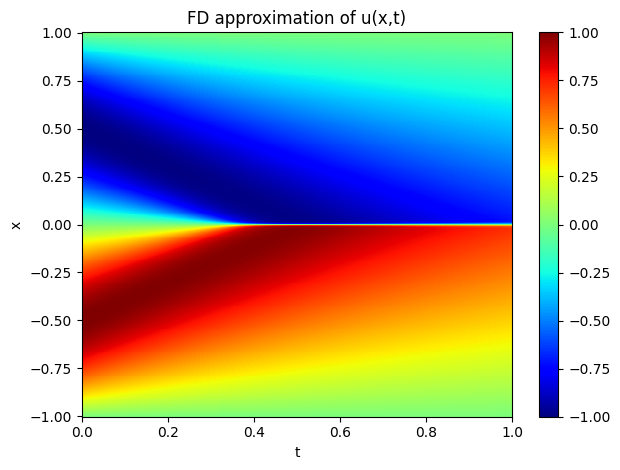

In [ ]:
u_fd = burgers_FD()

# Physics-Informed Neural Netowrk (PINN)

The following code is based on the theoratical work by Raissi et al.(2019).

The idea of Physics-Informed Neural Network (PINN) is to use a neural network (NN) to approximate the solution function of a nonlinear partial differential equation (PDE) or any differential equation in general and this is based on the fact that NNs are univeral functions approximators according to Hornik et al.(1989). That is, a feedforward neural network with one hidden layer and a nonlinear activation function can approximate any function from a finite a dimensional space to another with any desired degree of accuracy provided the use of sufficiently many hidden units[2].

PINNs incorperate the prior knowledge of the physical laws into the model to help reducing the number of possible solution to the differential equation. This includes the PDE itself and its boundary and initial conditions. To find the best model that approximates the solution $u(x,t)$, we must find the parameters of the NN that minimizes a loss function. The loss function will consider the PDE and its boundary and initial conditions as mentioned earlier and hence the name physics informed[3].

Let $\tilde{u}(x,t)$ be the approximated solution by the neural network. Furthermore, rearrange Burgers equation and define the following function

$$
f(x,t) = \tilde{u}_t + \tilde{u} \tilde{u}_x + \nu \tilde{u}_{xx}
$$

Since we know that $f(x,t) = 0$, we can use this in our loss function, which is usually taken as the measn square error between the predicted and the true values.

$$
MSE_{PDE} = \frac{1}{N_f} \sum_{i=1}^{N_f} \Big|f(x_i, t_i)\Big|^2
$$

Since $x\in [-1,1]$ and $t\in [0,1]$ then the collocation points are defined over the domain $(x_i, t_i) \in [-1,1] \, \times \, [0,1]$. $N_f$ is the number of collocation points.

We can define the loss due to the initial and boundary points in a similar way.

$$
MSE_{0} = \frac{1}{N_0} \sum_{i=1}^{N_0} \Big| \tilde{u}(x_i, t=0) + \sin(\pi x_i)\Big|^2
$$

Where $N_0$ is the number of initial points.

$$
MSE_{lb} = \frac{1}{N_{lb}} \sum_{i=1}^{N_{lb}} \Big| \tilde{u}(x=-1, t_i) \Big|^2
$$

$$
MSE_{rb} = \frac{1}{N_{rb}} \sum_{i=1}^{N_{rb}} \Big| \tilde{u}(x=1, t_i) \Big|^2
$$

Where $N_{lb}$ and $N_{rb}$ are the number of left boundary and right boundary points, respectively.

The loss function that we need to approximate is the sum of PDE, initial, and boundary losses. Therefore,

$$
MSE = MSE_{PDE} + MES_{init} + MSE_{lb} + MSE_{rb}
$$

**Note:** To compute the derivative of the output, $\tilde{u}(x,t)$ with respect to the inputs $x$ and $t$, we will utilize the Automatic differentiation algorithm proposed by Baydin et al.(2018), which is implemented in PyTorch.[4]

## Create Neural Network


In [ ]:
class FCN(nn.Module):
  def __init__(self, n_input, n_output, n_hidden_layers, n_hidden_units):
    super().__init__()
    self.n_input = n_input
    self.n_output = n_output
    self.n_hidden_layers = n_hidden_layers
    self.n_hidden_units = n_hidden_units

    self.input_layer = nn.Sequential(
        nn.Linear(self.n_input, self.n_hidden_units),
        nn.Tanh()
        )

    self.hidden_layers = []
    for i in range(n_hidden_layers - 1):
      self.hidden_layers.append(nn.Linear(self.n_hidden_units, self.n_hidden_units))
      self.hidden_layers.append(nn.Tanh())

    self.hidden_layers = nn.Sequential(*self.hidden_layers)
    self.output_layer = nn.Linear(self.n_hidden_units, self.n_output)

  def forward(self, x, t):
    input = torch.cat((x, t), axis=1)
    output = self.input_layer(input)
    output = self.hidden_layers(output)
    output = self.output_layer(output)
    return output

# Generate Training Data

In [ ]:
def generate_collocation(t_0, t_f, x_0, x_f,
                         n_t_points=100, n_x_points=100,
                         rand=True, exclude_boundary=True):
  if rand:
    x_axis = (x_0 - x_f) * torch.rand(n_x_points) + x_f
    t_axis = (t_0 - t_f) * torch.rand(n_t_points) + t_f

  else:
    if exclude_boundary:
      x_axis = torch.linspace(x_0, x_f, n_x_points + 2)[1:-1]
      t_axis = torch.linspace(t_0, t_f, n_t_points + 1)[1:]
    else:
      x_axis = torch.linspace(x_0, x_f, n_x_points)
      t_axis = torch.linspace(t_0, t_f, n_t_points)

  collocation = torch.cartesian_prod(t_axis, x_axis)
  return collocation

In [ ]:
t_0, t_f = 0.0, 1.0
x_0, x_f = -1.0, 1.0
n_x, n_t = 50, 50 #total collaction n_x * n_t
v = 0.01/pi

#generate data
collocation = generate_collocation(t_0, t_f, x_0, x_f, n_x, n_t, rand=False)
t_physics, x_physics = collocation.split(1, 1)
x_axis = torch.linspace(x_0, x_f, n_x).unsqueeze(-1)
t_axis = torch.linspace(t_0, t_f, n_t).unsqueeze(-1)
x_left = torch.tensor([x_0] * len(t_axis)).unsqueeze(-1)
x_right = torch.tensor([x_f] * len(t_axis)).unsqueeze(-1)
t_init = torch.tensor([t_0] * len(x_axis)).unsqueeze(-1)
u_init = init_cond( x_axis.numpy() )
u_init = torch.from_numpy(u_init)

#Add grad to the physics data
x_physics = x_physics.requires_grad_(True)
t_physics = t_physics.requires_grad_(True)

## Initialize the model

In [ ]:
pinn = FCN(2, 1, 4, 32)
optimizer = torch.optim.Adam(pinn.parameters(), lr=1e-4)

Running the following cell might take up to 5 minutes. If you would like, you can decrease the number of epochs.

**Note:** The code will be customized to run on GPU or CPU on the future.

inital: 0.004187645390629768
boundary: 0.00020298748859204352
pde: 0.0050064013339579105
total loss: 0.009397033601999283


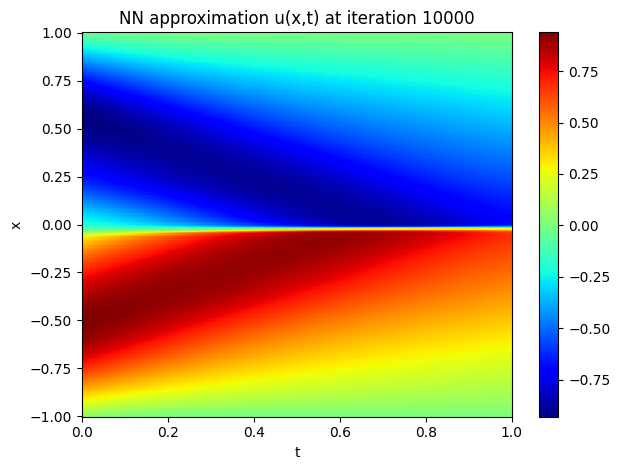

inital: 0.001992087112739682
boundary: 7.754200487397611e-05
pde: 0.0024315165355801582
total loss: 0.0045011453330516815


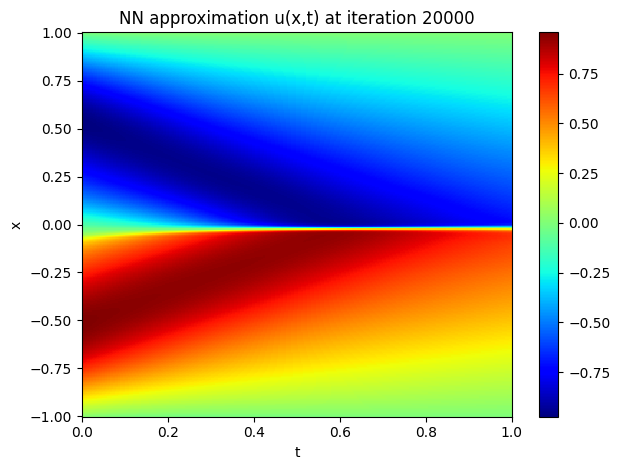

In [ ]:
epochs = 20000
pinn.train()
for epoch in range(1, epochs+1):
  optimizer.zero_grad()

  #initial data loss
  u = pinn(x_axis, t_init)
  init_loss = torch.mean( (u + torch.sin(pi * x_axis))**2 )

  #left boundary loss
  u = pinn(x_left, t_axis)
  left_boundary_loss = torch.mean( u**2 )

  #right boundary loss
  u = pinn(x_right, t_axis)
  right_boundary_loss = torch.mean( u**2 )

  boundary_loss = left_boundary_loss + right_boundary_loss

  #PDE loss
  u = pinn(x_physics, t_physics)
  u_x = torch.autograd.grad(u, x_physics, torch.ones_like(u), create_graph=True)[0]
  u_xx = torch.autograd.grad(u_x, x_physics, torch.ones_like(u_x), create_graph=True)[0]
  u_t = torch.autograd.grad(u, t_physics, torch.ones_like(u), create_graph=True)[0]
  pde_loss = torch.mean( (u_t + u * u_x - v * u_xx)**2 )

  loss = init_loss + boundary_loss + pde_loss
  loss.backward()
  optimizer.step()

  if epoch % 10000 == 0:
    pinn.eval()
    with torch.inference_mode():
      print(f"inital: {init_loss.item()}\n"
            f"boundary: {boundary_loss.item()}\n"
            f"pde: {pde_loss.item()}\n"
            f"total loss: {loss.item()}")

      x_axis_test = torch.linspace(x_0, x_f, 300)
      t_axis_test = torch.linspace(t_0, t_f, 300)
      test_data = torch.cartesian_prod(t_axis_test, x_axis_test)
      t_test, x_test = test_data.split(1, 1)
      u_approx = pinn(x_test, t_test)
      u_approx = u_approx.reshape(len(t_axis_test), len(x_axis_test))
      plot_result(t_axis_test.numpy(), x_axis_test.numpy(), u_approx.T.numpy(),
                  title=f"NN approximation u(x,t) at iteration {epoch}",
                  xlabel="t", ylabel="x")
      pinn.train()

# Comaprison of FD & NN

In [ ]:
def pinn_predict(x, t):
  pinn.eval()
  with torch.inference_mode():
    output = pinn(x, t)
  pinn.train()
  return output

In [ ]:
def compare():
  x_axis, t_axis, u_fd = burgers_FD(show_plot=False, return_axes=True)
  x_axis = torch.from_numpy(x_axis).type(torch.float32)
  t_axis = torch.from_numpy(t_axis).type(torch.float32)
  data = torch.cartesian_prod(t_axis, x_axis)
  t_input, x_input = data.split(1, 1)
  u_nn = pinn_predict(x_input, t_input)
  u_nn = u_nn.reshape(len(t_axis), len(x_axis))

  difference = u_nn.numpy() - u_fd
  abs_difference = abs(difference)
  mse = np.average(abs_difference**2)
  plot_result(t_axis.numpy(), x_axis.numpy(), abs_difference.T,
                  title=f"difference u(x,t) (MSE: {mse:.5f})",
                  xlabel="t", ylabel="x")

  return mse

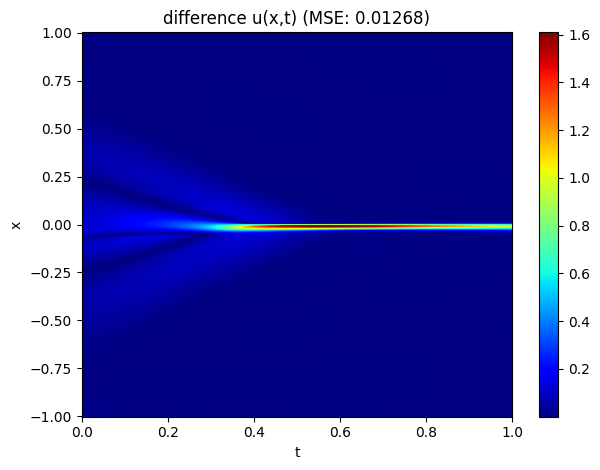

In [ ]:
mse = compare()

We notice that the difference between the reference solution and the one approximated by the neural network differs clearly around $x=0$ at $t \ge 0.4$. The reason might be due to the nature of Burgers equation where the solution becomes discontinuous for small diffusion coefficients $\nu \rightarrow 0$. To get a better approximation, one might need increase the number of hidden layers or the hidden units. Other option can be to increase the number of iterations. In the following cells, we look at the discontinuity of the solution and how it contributes to the large part of the error.

In [ ]:
def pinn_predict_t(t, n_x=200, show_plot=True):
  pinn.eval()
  with torch.inference_mode():
    x_axis = torch.linspace(x_0, x_f, n_x).unsqueeze(-1)
    t_data = torch.tensor([t] * n_x).unsqueeze(-1)
    u = pinn(x_axis, t_data).numpy()
    if show_plot:
      figure = plt.figure()
      ax = figure.add_subplot(111)
      ax.plot(x_axis, u, color="blue")
      ax.set_title(f"NN approximation u(x, t={t:.2f})")
      ax.set_xlabel("x")
      ax.set_ylabel("u")
  pinn.train()
  return u

In [ ]:
def compare_at_t(t, show_plot=False):
  u_fd = burgers_FD(t_f=t, show_plot=False)[-1]
  x_axis_fd = torch.linspace(x_0, x_f, len(u_fd))
  u_nn = pinn_predict_t(t, n_x=len(x_axis_fd), show_plot=False).squeeze()
  x_axis_nn = np.linspace(x_0, x_f, len(u_nn))
  difference = u_nn - u_fd
  abs_difference = abs(difference)
  mse = np.mean(abs_difference**2)

  if show_plot:
    figure = plt.figure(figsize=(5,4), tight_layout=True)
    ax = figure.add_subplot(111)
    ax.plot(x_axis_nn, u_fd, c="blue", label="FD")
    ax.plot(x_axis_nn, u_nn, c="red", linestyle="dashed", label="PINN")
    ax.set_title(f"u(x, t={t:.2f}) (MSE: {mse:.4f})")
    ax.set_xlabel("x")
    ax.set_ylabel(f"u(x, t={t:.2f})")
    plt.legend()
    plt.show()

  return difference

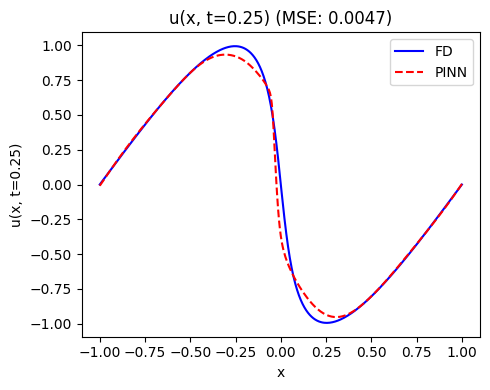

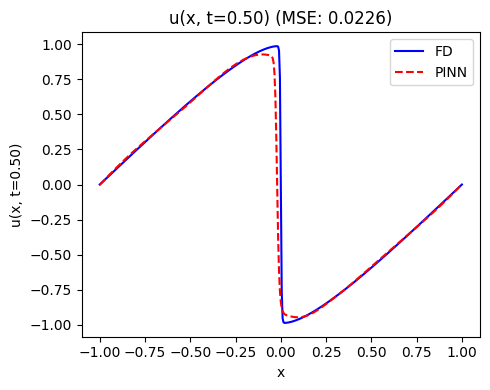

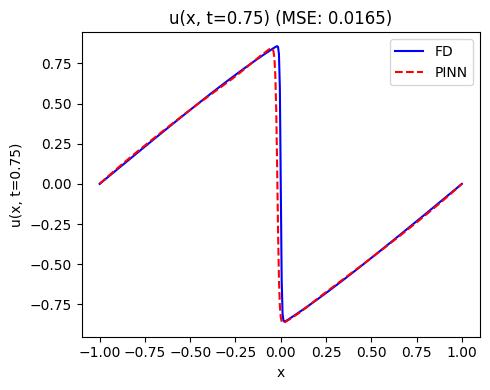

In [ ]:
for t in [0.25, 0.50, 0.75]:
  difference_at_t = compare_at_t(t, show_plot=True)

We observe in the figure above that the mean squared error for the discontinuous part is greater than the solution at early time $t\le 0.4$.

**Note:** This might not be case every time you run the code, but it is most likely to have greater error at the discontinuous part.

# References

[1] Kutluay, S., Bahadir, A. R., & Özdeş, A. (1999). Numerical solution of one-dimensional burgers equation: Explicit and exact-explicit finite difference methods. Journal of Computational and Applied Mathematics, 103(2), 251–261. https://doi.org/10.1016/s0377-0427(98)00261-1.

[2] Hornik, K., Stinchcombe, M., & White, H. (1989). Multilayer feedforward networks are universal approximators. Neural Networks, 2(5), 359–366. https://doi.org/10.1016/0893-6080(89)90020-8.

[3] Raissi, M., Perdikaris, P., & Karniadakis, G. E. (2019). Physics-informed Neural Networks: A deep learning framework for solving forward and inverse problems involving nonlinear partial differential equations. Journal of Computational Physics, 378, 686–707. https://doi.org/10.1016/j.jcp.2018.10.045.

[4] Baydin, A. G., Pearlmutter, B. A., Radul, A. A., & Siskind, J. M. (2018). Automatic differentiation in machine learning: a survey. Journal of Marchine Learning Research, 18, 1-43.